### Import dependencies

In [49]:
import os
import numpy as np
import pandas as pd
import librosa # for audio analysis capabilities
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Parse wav files

In [50]:
base_dir = "audio_speech"
mfcc_features = [] # for classical ML
mfcc_sequences = [] # for deep learning
file_names = []
# to store num of frames of the audio clips
seq_lens = []

# number of features to extract
n_mfcc = 13


for actor in os.listdir(base_dir):
    actor_path = os.path.join(base_dir, actor)

    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                file_path = os.path.join(actor_path, file)

                # load audio
                y, sr = librosa.load(file_path, sr=None) 
                # y: audio time series (1d array of amplitudes)
                # sr: sampling rate of y (number of samples per second, in Hz)
                # sr=None to preserve native sampling rate of the audio file

                # extract MFCC features
                mfcc = librosa.feature.mfcc(
                    y=y, 
                    sr=sr, 
                    n_mfcc=n_mfcc,
                    n_fft=int(0.025*sr),    # 25ms window
                    hop_length=int(0.01*sr) # 10ms step
                    )
                # window and step sizes conventionally 25ms and 10ms respectively
                # n_mfcc: number of features to extract, 13 is conventionally default (but 20-60 also widely used)
                # source: https://www.sciencedirect.com/science/article/pii/S0003682X2400450X#:~:text=The%20default%20MFCC%20parameters%20include,of%2010%20ms%20between%20frames. (3.2. Feature extraction)
                # source: https://medium.com/@MuhyEddin/feature-extraction-is-one-of-the-most-important-steps-in-developing-any-machine-learning-or-deep-94cf33a5dd46

                # average across time to get fixed length vector
                mfcc_mean = np.mean(mfcc, axis=1)
                # mfcc.shape = (n_mfcc, n_frames) -> which varies depending on length of clip
                # i.e. MFCCs for each recording is stored as rows x cols, where 1 row = 1 feature, and 1 col = 1 timeframe
                #   this means for each feature, average across all timeframes
                # this is needed for classical ML models since they require fixed length vectors
                # for CNNs/RNNs, this is not needed

                # store results
                mfcc_features.append(mfcc_mean)
                mfcc_sequences.append(mfcc.T)

                # keep track of filename
                file_names.append(file)

                # to find out pad length for DL
                seq_lens.append(mfcc.shape[1])

# create DataFrame
mfcc_df = pd.DataFrame(mfcc_features, columns=[f"mfcc_{i+1}" for i in range(n_mfcc)])
mfcc_df.insert(0, "file_name", file_names)

In [51]:
mfcc_df.head()

,file_name,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,03-01-01-01-01-01-01.wav,-781.682495,70.058044,5.147651,13.097836,6.758105,14.325360,-1.989439,3.493909,-2.366243,-0.921622,-6.919755,-1.241252,3.518741
1,03-01-01-01-01-02-01.wav,-772.464417,71.130180,3.469762,13.903845,9.011167,14.973162,-2.901312,4.907290,-2.620109,-2.943348,-6.704802,-0.728328,3.617220
2,03-01-01-01-02-01-01.wav,-777.258667,72.458061,5.855737,13.510947,7.557459,12.344082,-1.818045,5.427038,-3.593992,-1.614108,-6.691478,-1.833791,2.607487
3,03-01-01-01-02-02-01.wav,-773.044861,70.795067,7.784384,14.736279,7.278001,13.929562,-0.823848,6.634629,-4.111044,-2.503031,-6.650910,-0.833154,3.223252
4,03-01-02-01-01-01-01.wav,-814.073425,76.804420,8.059467,15.544461,7.396242,15.151326,-1.988484,4.947098,-4.235058,-0.008154,-6.758834,-2.809847,2.709928


### Import laballed RAVDESS data to join with vectorized data

In [52]:
# Read in the labelled data
labels_df = pd.read_csv("ravdess_labels.csv")

## Classical ML Dataset

In [53]:
# Join with the vectorized data
classical_df = pd.merge(mfcc_df, labels_df, on="file_name")
classical_df.head()

,file_name,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,Vocal_channel,Emotion,Emotional_intensity,Statement,Repetition,Actor,Emotion_label,Intensity_label,Statement_label,Actor_gender
0,03-01-01-01-01-01-01.wav,-781.682495,70.058044,5.147651,13.097836,6.758105,14.325360,-1.989439,3.493909,-2.366243,...,1,1,1,1,1,1,neutral,normal,Kids are talking by the door,male
1,03-01-01-01-01-02-01.wav,-772.464417,71.130180,3.469762,13.903845,9.011167,14.973162,-2.901312,4.907290,-2.620109,...,1,1,1,1,2,1,neutral,normal,Kids are talking by the door,male
2,03-01-01-01-02-01-01.wav,-777.258667,72.458061,5.855737,13.510947,7.557459,12.344082,-1.818045,5.427038,-3.593992,...,1,1,1,2,1,1,neutral,normal,Dogs are sitting by the door,male
3,03-01-01-01-02-02-01.wav,-773.044861,70.795067,7.784384,14.736279,7.278001,13.929562,-0.823848,6.634629,-4.111044,...,1,1,1,2,2,1,neutral,normal,Dogs are sitting by the door,male
4,03-01-02-01-01-01-01.wav,-814.073425,76.804420,8.059467,15.544461,7.396242,15.151326,-1.988484,4.947098,-4.235058,...,1,2,1,1,1,1,calm,normal,Kids are talking by the door,male


In [54]:
X_classical = classical_df[[f"mfcc_{i+1}" for i in range(n_mfcc)]].values
y_classical = classical_df["Emotion"].values

### Export file as csv

In [55]:
classical_df.to_csv("ravdess_mfcc_features_averaged.csv", index=False)

## Deep Learning Dataset

### Finding audio length

In [56]:
seq_lens = np.array(seq_lens)

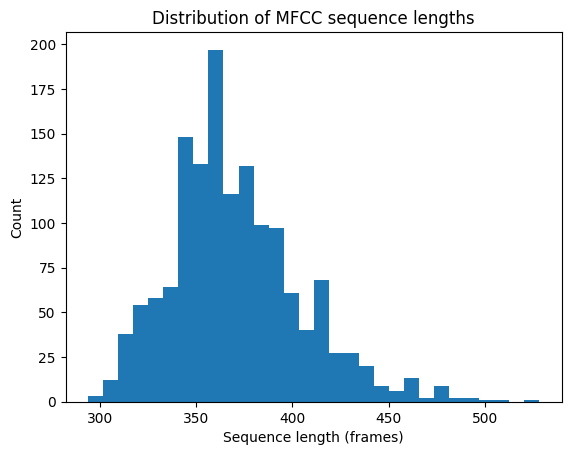

In [57]:
plt.hist(seq_lens, bins=30)
plt.xlabel("Sequence length (frames)")
plt.ylabel("Count")
plt.title("Distribution of MFCC sequence lengths")
plt.show()

In [58]:
print(min(seq_lens))
print(max(seq_lens))
print((np.median(seq_lens)))

# Since no extremely large outliers, we dont need to truncate. Just pad until the longest seq_len

294
528
368.0


### Extract padded MFCCs

In [59]:
# Pad sequences to same length
X_deep = pad_sequences(mfcc_sequences, padding='post', dtype='float32')
# padding='post' to add 0s after the sequence ends if shorter than maxlen

In [60]:
# Align labels with file_names order
deep_labels_df = labels_df.set_index('file_name').loc[file_names].reset_index()
y_deep = deep_labels_df["Emotion"].values 

In [61]:
print("CLASSICAL MODEL DATA")
print(f"x: {X_classical}")
print(f"Shape of x: {X_classical.shape}\n\n\n\n\n")
print(f"y: {y_classical}")
print(f"Shape of y: {y_classical.shape}")

CLASSICAL MODEL DATA
x: [[-7.8168250e+02  7.0058044e+01  5.1476507e+00 ... -6.9197550e+00
  -1.2412518e+00  3.5187407e+00]
 [-7.7246442e+02  7.1130180e+01  3.4697623e+00 ... -6.7048020e+00
  -7.2832829e-01  3.6172197e+00]
 [-7.7725867e+02  7.2458061e+01  5.8557367e+00 ... -6.6914778e+00
  -1.8337907e+00  2.6074867e+00]
 ...
 [-6.3365790e+02  5.4886353e+01 -1.9845383e+01 ... -2.7730572e+00
  -1.0348324e+00 -4.2581177e+00]
 [-5.8053693e+02  4.6058212e+01 -1.2476372e+01 ... -2.1553283e+00
  -3.9990695e+00 -6.7004952e+00]
 [-5.8786353e+02  4.3486069e+01 -7.0004802e+00 ... -6.4173512e+00
  -3.0535800e+00 -5.6978593e+00]]
Shape of x: (1440, 13)





y: [1 1 1 ... 8 8 8]
Shape of y: (1440,)


In [62]:
print("DEEP LEARNING MODEL DATA")
print(f"x: {X_deep}\n\n\n\n\n")

DEEP LEARNING MODEL DATA
x: [[[-915.0749       0.           0.        ...    0.           0.
      0.       ]
  [-915.0749       0.           0.        ...    0.           0.
      0.       ]
  [-915.0749       0.           0.        ...    0.           0.
      0.       ]
  ...
  [   0.           0.           0.        ...    0.           0.
      0.       ]
  [   0.           0.           0.        ...    0.           0.
      0.       ]
  [   0.           0.           0.        ...    0.           0.
      0.       ]]

 [[-910.79816      0.           0.        ...    0.           0.
      0.       ]
  [-910.79816      0.           0.        ...    0.           0.
      0.       ]
  [-910.79816      0.           0.        ...    0.           0.
      0.       ]
  ...
  [   0.           0.           0.        ...    0.           0.
      0.       ]
  [   0.           0.           0.        ...    0.           0.
      0.       ]
  [   0.           0.           0.        ...    0.     

In [63]:
print(f"Shape of X: {X_deep.shape}\n\n\n\n\n")
print(f"y: {y_deep}")
print(f"Shape of y: {y_deep.shape}")

Shape of X: (1440, 528, 13)





y: [1 1 1 ... 8 8 8]
Shape of y: (1440,)
